# Imports

In [22]:
import torch  # Import the PyTorch library
import torchvision
import torch.nn as nn
import importlib
from torchvision import transforms
import numpy as np
from torchsummary import summary

import torch.optim as optim  # Optimization algorithms for training the model
import torch.nn.functional as F  # Common loss functions and activation functions
from scipy.stats import spearmanr, pearsonr  # Statistical functions for correlation calculation
import itertools  # Utility functions for generating combinations
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduler for training
import matplotlib.pyplot as plt  # Plotting library for visualization

import mlflow

# Check if GPU (Graphics Processing Unit) is available for training
import utils
from utils import datenum_to_datetime, FacesDataset
import models
importlib.reload(utils)
importlib.reload(models)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# Define the device to use for training based on GPU availability
device = torch.device("cuda:0" if train_on_gpu else "cpu")

CUDA is not available.  Training on CPU ...


# Preprocessing

In [14]:
import pickle

# Define data transformations (augmentations for training and normalization)
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally for training augmentation
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values based on ImageNet statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256 (consistent with training)
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values using the same statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Set batch size
bs = 32

# Create datasets for training, validation, and testing
print("Train set:")
trainset = FacesDataset("imdb_crop", transform_train, split="train")
print("Validation set:")
valset = FacesDataset("imdb_crop", transform_val, split="val")
print("Test set:")
testset = FacesDataset("imdb_crop", transform_val, split="test")

# Create data loaders for efficient batch training and evaluation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# Print dataset and dataloader lengths (number of samples and batches)
print(f"Number of training samples: {len(trainloader) * bs}")
print(f"Number of validation samples: {len(valloader)}")
print(f"Number of test samples: {len(testloader)}")

Train set:
Before processing:
(460723, 5)
                                        full_path  ...  face_score
0   [01/nm0000001_rm124825600_1899-5-10_1968.jpg]  ...    1.459693
1  [01/nm0000001_rm3343756032_1899-5-10_1970.jpg]  ...    2.543198
2   [01/nm0000001_rm577153792_1899-5-10_1968.jpg]  ...    3.455579
3   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]  ...    1.872117
4   [01/nm0000001_rm980463616_1899-5-10_1968.jpg]  ...    1.158766

[5 rows x 5 columns]
After processing:
(71828, 2)
                                            full_path  age
7   imdb_crop/02/nm0000002_rm1363385088_1924-9-16_...   80
15  imdb_crop/02/nm0000002_rm2585828096_1924-9-16_...   82
18  imdb_crop/02/nm0000002_rm2769394176_1924-9-16_...   82
19  imdb_crop/02/nm0000002_rm2780403712_1924-9-16_...   80
23  imdb_crop/02/nm0000002_rm2983566080_1924-9-16_...   83
Shuffled indices (first 5): [24882  6199  1963 27427 30965]
Validation set:
Shuffled indices (first 5): [24882  6199  1963 27427 30965]
Test set:
Shuff

# first model mobilenet

In [20]:
net = models.mobilenetv2
net.to(device)
summary(net, (3, 256, 256));  # Input shape (channels, height, width)

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1280, 8, 8]          --
|    └─Conv2dNormActivation: 2-1                   [-1, 32, 128, 128]        --
|    |    └─Conv2d: 3-1                            [-1, 32, 128, 128]        864
|    |    └─BatchNorm2d: 3-2                       [-1, 32, 128, 128]        64
|    |    └─ReLU6: 3-3                             [-1, 32, 128, 128]        --
|    └─InvertedResidual: 2-2                       [-1, 16, 128, 128]        --
|    |    └─Sequential: 3-4                        [-1, 16, 128, 128]        896
|    └─InvertedResidual: 2-3                       [-1, 24, 64, 64]          --
|    |    └─Sequential: 3-5                        [-1, 24, 64, 64]          5,136
|    └─InvertedResidual: 2-4                       [-1, 24, 64, 64]          --
|    |    └─Sequential: 3-6                        [-1, 24, 64, 64]          8,832
|    └─InvertedResidual: 2-

**Transfer learning**

Train only the last layers

In [24]:
# Freeze pre-trained layers and unfreeze the classifier for fine-tuning
for key, value in dict(net.named_children()).items():
    if "classifier" in key:
        for param in value.parameters():
            param.requires_grad = True
            print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)
    else:
        for param in value.parameters():
            param.requires_grad = False
            # print(param)  # Commented out to avoid printing individual parameters
summary(net);

Unfreezing layer: classifier, Parameter shape: torch.Size([512, 1280])
Unfreezing layer: classifier, Parameter shape: torch.Size([512])
Unfreezing layer: classifier, Parameter shape: torch.Size([32, 512])
Unfreezing layer: classifier, Parameter shape: torch.Size([32])
Unfreezing layer: classifier, Parameter shape: torch.Size([1, 32])
Unfreezing layer: classifier, Parameter shape: torch.Size([1])
Layer (type:depth-idx)                             Param #
├─Sequential: 1-1                                  --
|    └─Conv2dNormActivation: 2-1                   --
|    |    └─Conv2d: 3-1                            (864)
|    |    └─BatchNorm2d: 3-2                       (64)
|    |    └─ReLU6: 3-3                             --
|    └─InvertedResidual: 2-2                       --
|    |    └─Sequential: 3-4                        (896)
|    └─InvertedResidual: 2-3                       --
|    |    └─Sequential: 3-5                        (5,136)
|    └─InvertedResidual: 2-4               

# Training Function

In [18]:
# Define training parameters (epochs, loss function, optimizer, and scheduler)
epochs = 2  # Number of training epochs
criterion = nn.L1Loss()  # L1 loss function for regression (mean absolute error)
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
scheduler = CosineAnnealingLR(optimizer,
                              T_max=len(trainloader) * epochs,  # Maximum number of iterations for scheduler
                              eta_min=1e-5)  # Minimum learning rate for scheduler

Test loss: 0.077182	PLCC: 0.651	SROCC: 0.585


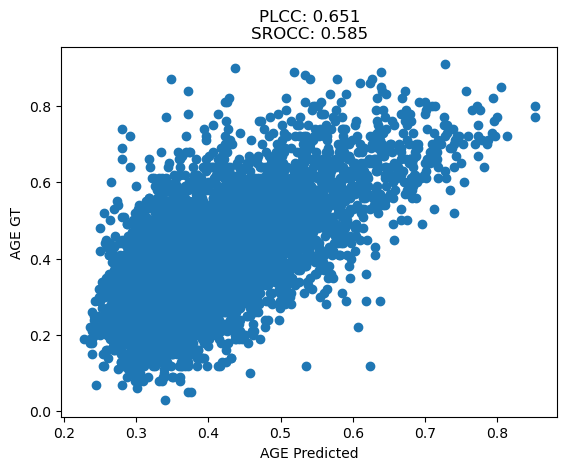

In [22]:
def train_model(model, epochs):
    mlflow.start_run()
    mlflow.log_param("model_type", type(model).__name__)
    mlflow.log_param("epochs", epochs)

    for epoch in range(epochs):
        running_loss = []
        gt_labels = []
        pr_labels = []

        model.train()

        for i, data in enumerate(trainloader):
            inputs, labels = data["image"], data["age"]
            gt_labels.append(labels.cpu().numpy())

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            pr_labels.append(outputs.squeeze().detach().cpu())

            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss.append(loss.item())
            if (i + 1) % (len(trainloader) // 10) == 0:
                gt_labels = np.concatenate(gt_labels).squeeze()
                pr_labels = np.concatenate(pr_labels).squeeze()

                s = spearmanr(gt_labels, pr_labels)[0]
                p = pearsonr(gt_labels, pr_labels)[0]
                print('%d, [%d, %d] loss: %.4f\tPLCC: %.3f\tSROCC: %.3f\tlr: %.6f' %
                      (epoch + 1, i + 1, len(trainloader), np.mean(running_loss), p, s, optimizer.param_groups[-1]['lr']))
                
                mlflow.log_metrics({'loss': np.mean(running_loss), 'PLCC': p, 'SROCC': s}, step=epoch)

                gt_labels = []
                pr_labels = []
                running_loss = []

        # Code for validation loop goes here ...

    # Save the final model
    final_model_path = "final_model.pth"
    torch.save(model.state_dict(), final_model_path)
    mlflow.log_artifact(final_model_path)

    # Testing loop
    running_loss = []
    gt_labels = []
    pr_labels = []

    model.eval()

    for i, data in enumerate(testloader):
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.item())

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)

        pr_labels.append(outputs.squeeze().item())
        loss = criterion(outputs.squeeze(), labels.squeeze())
        running_loss.append(loss.item())

    gt_labels = np.array(gt_labels)
    pr_labels = np.array(pr_labels)
    s = spearmanr(gt_labels, pr_labels)[0]
    p = pearsonr(gt_labels, pr_labels)[0]
    print('Test loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

    # Log test metrics to MLflow
    mlflow.log_metrics({'test_loss': np.mean(running_loss), 'test_PLCC': p, 'test_SROCC': s})

    # Optional: Plotting
    plt.scatter(pr_labels, gt_labels)
    plt.xlabel("AGE Predicted")
    plt.ylabel("AGE GT")
    plt.title(f"PLCC: {p:.3f}\nSROCC: {s:.3f}")
    plt.savefig(f"{type(model).__name__}_test_performance.png")
    plt.show()
    plt.close()

    mlflow.end_run()
    print('Finished Training')

**!ASSIGNMENT!**

*Transfer learning*
1. Finetune all the layers of the current network (mobilenet_v2).

In [25]:
# task 1
summary(net);

Layer (type:depth-idx)                             Param #
├─Sequential: 1-1                                  --
|    └─Conv2dNormActivation: 2-1                   --
|    |    └─Conv2d: 3-1                            (864)
|    |    └─BatchNorm2d: 3-2                       (64)
|    |    └─ReLU6: 3-3                             --
|    └─InvertedResidual: 2-2                       --
|    |    └─Sequential: 3-4                        (896)
|    └─InvertedResidual: 2-3                       --
|    |    └─Sequential: 3-5                        (5,136)
|    └─InvertedResidual: 2-4                       --
|    |    └─Sequential: 3-6                        (8,832)
|    └─InvertedResidual: 2-5                       --
|    |    └─Sequential: 3-7                        (10,000)
|    └─InvertedResidual: 2-6                       --
|    |    └─Sequential: 3-8                        (14,848)
|    └─InvertedResidual: 2-7                       --
|    |    └─Sequential: 3-9                    

In [28]:
# Freeze pre-trained layers and unfreeze the classifier for fine-tuning
for key, value in dict(net.named_children()).items():
    for param in value.parameters():
        param.requires_grad = True
        print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)

Unfreezing layer: features, Parameter shape: torch.Size([32, 3, 3, 3])
Unfreezing layer: features, Parameter shape: torch.Size([32])
Unfreezing layer: features, Parameter shape: torch.Size([32])
Unfreezing layer: features, Parameter shape: torch.Size([32, 1, 3, 3])
Unfreezing layer: features, Parameter shape: torch.Size([32])
Unfreezing layer: features, Parameter shape: torch.Size([32])
Unfreezing layer: features, Parameter shape: torch.Size([16, 32, 1, 1])
Unfreezing layer: features, Parameter shape: torch.Size([16])
Unfreezing layer: features, Parameter shape: torch.Size([16])
Unfreezing layer: features, Parameter shape: torch.Size([96, 16, 1, 1])
Unfreezing layer: features, Parameter shape: torch.Size([96])
Unfreezing layer: features, Parameter shape: torch.Size([96])
Unfreezing layer: features, Parameter shape: torch.Size([96, 1, 3, 3])
Unfreezing layer: features, Parameter shape: torch.Size([96])
Unfreezing layer: features, Parameter shape: torch.Size([96])
Unfreezing layer: featu

In [28]:
summary(net);

Layer (type:depth-idx)                             Param #
├─Sequential: 1-1                                  --
|    └─Conv2dNormActivation: 2-1                   --
|    |    └─Conv2d: 3-1                            (864)
|    |    └─BatchNorm2d: 3-2                       (64)
|    |    └─ReLU6: 3-3                             --
|    └─InvertedResidual: 2-2                       --
|    |    └─Sequential: 3-4                        (896)
|    └─InvertedResidual: 2-3                       --
|    |    └─Sequential: 3-5                        (5,136)
|    └─InvertedResidual: 2-4                       --
|    |    └─Sequential: 3-6                        (8,832)
|    └─InvertedResidual: 2-5                       --
|    |    └─Sequential: 3-7                        (10,000)
|    └─InvertedResidual: 2-6                       --
|    |    └─Sequential: 3-8                        (14,848)
|    └─InvertedResidual: 2-7                       --
|    |    └─Sequential: 3-9                    

In [ ]:
# Define training parameters (epochs, loss function, optimizer, and scheduler)
epochs = 2  # Number of training epochs
criterion = nn.L1Loss()  # L1 loss function for regression (mean absolute error)
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
scheduler = CosineAnnealingLR(optimizer,
                              T_max=len(trainloader) * epochs,  # Maximum number of iterations for scheduler
                              eta_min=1e-5)  # Minimum learning rate for scheduler


1, [67, 674] loss: 0.0752	PLCC: 0.680	SROCC: 0.631	lr: 0.000016
1, [134, 674] loss: 0.0711	PLCC: 0.697	SROCC: 0.668	lr: 0.000034
1, [201, 674] loss: 0.0730	PLCC: 0.703	SROCC: 0.658	lr: 0.000063
1, [268, 674] loss: 0.0705	PLCC: 0.706	SROCC: 0.660	lr: 0.000103
1, [335, 674] loss: 0.0715	PLCC: 0.717	SROCC: 0.678	lr: 0.000153
1, [402, 674] loss: 0.0689	PLCC: 0.737	SROCC: 0.715	lr: 0.000212
1, [469, 674] loss: 0.0672	PLCC: 0.742	SROCC: 0.710	lr: 0.000277
1, [536, 674] loss: 0.0666	PLCC: 0.730	SROCC: 0.698	lr: 0.000349
1, [603, 674] loss: 0.0656	PLCC: 0.736	SROCC: 0.719	lr: 0.000423
1, [670, 674] loss: 0.0653	PLCC: 0.740	SROCC: 0.715	lr: 0.000500
Validation loss: 0.075548	PLCC: 0.766	SROCC: 0.747


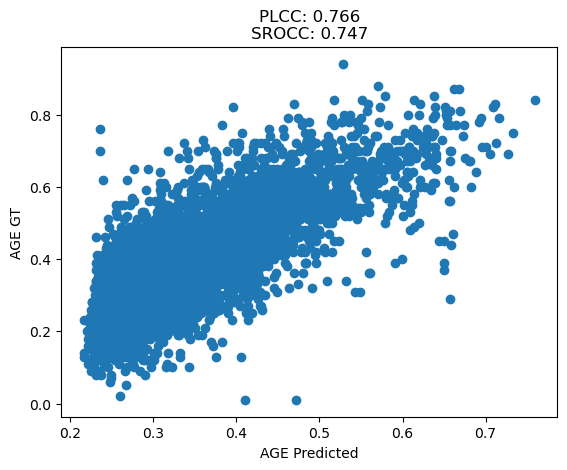

2, [67, 674] loss: 0.0643	PLCC: 0.763	SROCC: 0.744	lr: 0.000582
2, [134, 674] loss: 0.0662	PLCC: 0.752	SROCC: 0.728	lr: 0.000657
2, [201, 674] loss: 0.0644	PLCC: 0.749	SROCC: 0.725	lr: 0.000728
2, [268, 674] loss: 0.0679	PLCC: 0.745	SROCC: 0.729	lr: 0.000794
2, [335, 674] loss: 0.0662	PLCC: 0.754	SROCC: 0.734	lr: 0.000853
2, [402, 674] loss: 0.0636	PLCC: 0.764	SROCC: 0.747	lr: 0.000904


KeyboardInterrupt: 

In [26]:
# Training loop
for epoch in range(epochs):  # Loop over the dataset for multiple epochs
    running_loss = []  # List to store training loss for each batch
    gt_labels = []  # List to store ground truth labels (predicted age)
    pr_labels = []  # List to store predicted labels (model output)

    net.train()  # Set the model to training mode (enables dropout and other training-specific behaviors)

    for i, data in enumerate(trainloader):
        # Get inputs and labels from the data loader
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.cpu().numpy())   # Append ground truth

        inputs = inputs.to(device)  # Move data to the appropriate device (CPU or GPU)
        labels = labels.to(device)  # Move labels to the appropriate device

        # Zero the parameter gradients before each backward pass
        optimizer.zero_grad()

        # Forward pass, calculate loss
        outputs = net(inputs)  # Get model predictions

        loss = criterion(outputs.squeeze(), labels)  # Calculate L1 loss between predictions and true labels
        pr_labels.append(outputs.squeeze().detach().cpu())  # Store predictions (detach to avoid gradients)

        # Backward pass and parameter update
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights based on gradients
        scheduler.step()  # Update learning rate according to the scheduler

        # Print statistics (every 10% of the training data)
        running_loss.append(loss.item())
        if (i + 1) % (len(trainloader) // 10) == 0:  # Every 10% of the epoch
            gt_labels = np.stack(list(itertools.chain.from_iterable(gt_labels))).squeeze()  # Combine ground truth labels
            pr_labels = np.stack(list(itertools.chain.from_iterable(pr_labels))).squeeze()  # Combine predictions

            # Calculate and print performance metrics (PLCC, SROCC, learning rate)
            s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
            p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
            print('%d, [%d, %d] loss: %.4f\tPLCC: %.3f\tSROCC: %.3f\tlr: %.6f' %
                  (epoch + 1, i + 1, len(trainloader), np.mean(running_loss), p, s, optimizer.param_groups[-1]['lr']))

            # Clear lists for next iteration within the epoch
            gt_labels = []
            pr_labels = []
            running_loss = []

    # Validation loop (after each training epoch)
    running_loss = []  # List to store validation loss for each batch
    gt_labels = []  # List to store ground truth labels (predicted age)
    pr_labels = []  # List to store predicted labels (model output)

    net.eval()  # Set the model to evaluation mode (deactivates dropout and other training behaviors)

    for i, data in enumerate(valloader):
        # Get inputs and labels from the data loader
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.item())  # Append ground truth as single values

        inputs = inputs.to(device)  # Move data to the appropriate device
        labels = labels.to(device)  # Move labels to the appropriate device

        # Forward pass with gradient suppression
        with torch.no_grad():
            outputs = net(inputs)  # Get model predictions without calculating gradients

        pr_labels.append(outputs.squeeze().item())  # Append predictions as single values
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Calculate L1 loss
        running_loss.append(loss.item())

    # Calculate and print validation performance metrics
    gt_labels = np.stack(gt_labels)  # Combine ground truth labels
    pr_labels = np.stack(pr_labels)  # Combine predictions
    s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
    p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
    print('Validation loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

    # Visualization (optional)
    plt.scatter(pr_labels, gt_labels)
    plt.xlabel("AGE Predicted")
    plt.ylabel("AGE GT")
    plt.title("PLCC: %.3f\nSROCC: %.3f" % (p, s))
    plt.show()

    # Save the model (optional)
    torch.save(net.state_dict(), f"net_last_e{epoch}.pth")  # Save model state after each epoch

print('Finished Training')

In [ ]:
# Testing loop (after training)
running_loss = []  # List to store test loss for each batch
gt_labels = []  # List to store ground truth labels (predicted age)
pr_labels = []  # List to store predicted labels (model output)

net.eval()  # Set the model to evaluation mode (deactivates dropout and other training behaviors)

for i, data in enumerate(testloader):
    # Get inputs and labels from the data loader
    inputs, labels = data["image"], data["age"]
    gt_labels.append(labels.item())  # Append ground truth as single values

    inputs = inputs.to(device)  # Move data to the appropriate device
    labels = labels.to(device)  # Move labels to the appropriate device

    # Forward pass with gradient suppression
    with torch.no_grad():
        outputs = net(inputs)  # Get model predictions without calculating gradients

    pr_labels.append(outputs.squeeze().item())  # Append predictions as single values
    loss = criterion(outputs.squeeze(), labels.squeeze())  # Calculate L1 loss
    running_loss.append(loss.item())

# Calculate and print test performance metrics
gt_labels = np.stack(gt_labels)  # Combine ground truth labels
pr_labels = np.stack(pr_labels)  # Combine predictions
s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
print('Test loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

# Visualization (optional)
plt.scatter(pr_labels, gt_labels)
plt.xlabel("AGE Predicted")
plt.ylabel("AGE GT")
plt.title("PLCC: %.3f\nSROCC: %.3f" % (p, s))
plt.show()

2. Swap out the current model with a new one from [here](https://pytorch.org/vision/main/models.html#classification) that is already trained on Imagenet. Then, fine-tune the network and compare how well it performs on the test-set compared to the current network (mobilenet_v2) using PLCC and SROCC metrics.

In [48]:
import torchvision
import torch.nn as nn

net = torchvision.models.vit_b_16(weights='IMAGENET1K_V1')  # Load pre-trained weights

In [49]:
from torchsummary import summary
summary(net);

Layer (type:depth-idx)                        Param #
├─Conv2d: 1-1                                 590,592
├─Encoder: 1-2                                --
|    └─Dropout: 2-1                           --
|    └─Sequential: 2-2                        --
|    |    └─EncoderBlock: 3-1                 7,087,872
|    |    └─EncoderBlock: 3-2                 7,087,872
|    |    └─EncoderBlock: 3-3                 7,087,872
|    |    └─EncoderBlock: 3-4                 7,087,872
|    |    └─EncoderBlock: 3-5                 7,087,872
|    |    └─EncoderBlock: 3-6                 7,087,872
|    |    └─EncoderBlock: 3-7                 7,087,872
|    |    └─EncoderBlock: 3-8                 7,087,872
|    |    └─EncoderBlock: 3-9                 7,087,872
|    |    └─EncoderBlock: 3-10                7,087,872
|    |    └─EncoderBlock: 3-11                7,087,872
|    |    └─EncoderBlock: 3-12                7,087,872
|    └─LayerNorm: 2-3                         1,536
├─Sequential: 1-3    

In [52]:
net.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [53]:
in_feat_old = net.heads.head.in_features
net.heads = nn.Sequential(
    nn.Linear(in_feat_old, 512),  
    nn.GELU(),                 
    nn.Linear(512, 32),        
    nn.GELU(),                 
    nn.Linear(32, 1)           
)


In [54]:
net.heads

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): GELU(approximate='none')
  (2): Linear(in_features=512, out_features=32, bias=True)
  (3): GELU(approximate='none')
  (4): Linear(in_features=32, out_features=1, bias=True)
)

In [55]:
for key, value in dict(net.named_children()).items():
    print(key)

conv_proj
encoder
heads


In [56]:
# Freeze pre-trained layers and unfreeze the classifier for fine-tuning
for key, value in dict(net.named_children()).items():
    if "heads" in key:
        for param in value.parameters():
            param.requires_grad = True
            print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)
    else:
        for param in value.parameters():
            param.requires_grad = False
            # print(param)  # Commented out to avoid printing individual parameters

Unfreezing layer: heads, Parameter shape: torch.Size([512, 768])
Unfreezing layer: heads, Parameter shape: torch.Size([512])
Unfreezing layer: heads, Parameter shape: torch.Size([32, 512])
Unfreezing layer: heads, Parameter shape: torch.Size([32])
Unfreezing layer: heads, Parameter shape: torch.Size([1, 32])
Unfreezing layer: heads, Parameter shape: torch.Size([1])


In [57]:
summary(net);

Layer (type:depth-idx)                        Param #
├─Conv2d: 1-1                                 (590,592)
├─Encoder: 1-2                                --
|    └─Dropout: 2-1                           --
|    └─Sequential: 2-2                        --
|    |    └─EncoderBlock: 3-1                 (7,087,872)
|    |    └─EncoderBlock: 3-2                 (7,087,872)
|    |    └─EncoderBlock: 3-3                 (7,087,872)
|    |    └─EncoderBlock: 3-4                 (7,087,872)
|    |    └─EncoderBlock: 3-5                 (7,087,872)
|    |    └─EncoderBlock: 3-6                 (7,087,872)
|    |    └─EncoderBlock: 3-7                 (7,087,872)
|    |    └─EncoderBlock: 3-8                 (7,087,872)
|    |    └─EncoderBlock: 3-9                 (7,087,872)
|    |    └─EncoderBlock: 3-10                (7,087,872)
|    |    └─EncoderBlock: 3-11                (7,087,872)
|    |    └─EncoderBlock: 3-12                (7,087,872)
|    └─LayerNorm: 2-3                         (

In [58]:
# Define training parameters (epochs, loss function, optimizer, and scheduler)
epochs = 10  # Number of training epochs
criterion = nn.L1Loss()  # L1 loss function for regression (mean absolute error)
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
scheduler = CosineAnnealingLR(optimizer,
                              T_max=len(trainloader) * epochs,  # Maximum number of iterations for scheduler
                              eta_min=1e-5)  # Minimum learning rate for scheduler


In [46]:
## resizing images + transformer doesnt have adaptiva pooling layer - like 
# so i need to resize all the images in training and test set 224 x 224 instead of 256

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 256x256
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally for training augmentation
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values based on ImageNet statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 256x256 (consistent with training)
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values using the same statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Set batch size
bs = 32

# Create datasets for training, validation, and testing
print("Train set:")
trainset = FacesDataset("imdb_crop", transform_train, split="train")
print("Validation set:")
valset = FacesDataset("imdb_crop", transform_val, split="val")
print("Test set:")
testset = FacesDataset("imdb_crop", transform_val, split="test")

# Create data loaders for efficient batch training and evaluation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# Print dataset and dataloader lengths (number of samples and batches)
print(f"Number of training samples: {len(trainloader) * bs}")
print(f"Number of validation samples: {len(valloader)}")
print(f"Number of test samples: {len(testloader)}")

Train set:
Before processing:
(460723, 5)
                                        full_path     dob  photo_taken  \
0   [01/nm0000001_rm124825600_1899-5-10_1968.jpg]  693726         1968   
1  [01/nm0000001_rm3343756032_1899-5-10_1970.jpg]  693726         1970   
2   [01/nm0000001_rm577153792_1899-5-10_1968.jpg]  693726         1968   
3   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]  693726         1968   
4   [01/nm0000001_rm980463616_1899-5-10_1968.jpg]  693726         1968   

   second_face_score  face_score  
0           1.118973    1.459693  
1           1.852008    2.543198  
2           2.985660    3.455579  
3                NaN    1.872117  
4                NaN    1.158766  
After processing:
(71828, 2)
                                            full_path  age
7   imdb_crop/02/nm0000002_rm1363385088_1924-9-16_...   80
15  imdb_crop/02/nm0000002_rm2585828096_1924-9-16_...   82
18  imdb_crop/02/nm0000002_rm2769394176_1924-9-16_...   82
19  imdb_crop/02/nm0000002_rm278040371

1, [67, 674] loss: 0.1054	PLCC: 0.276	SROCC: 0.297	lr: 0.001000
1, [134, 674] loss: 0.0891	PLCC: 0.474	SROCC: 0.425	lr: 0.000999
1, [201, 674] loss: 0.0873	PLCC: 0.504	SROCC: 0.466	lr: 0.000998
1, [268, 674] loss: 0.0848	PLCC: 0.547	SROCC: 0.482	lr: 0.000996
1, [335, 674] loss: 0.0827	PLCC: 0.559	SROCC: 0.512	lr: 0.000994
1, [402, 674] loss: 0.0843	PLCC: 0.589	SROCC: 0.532	lr: 0.000991
1, [469, 674] loss: 0.0825	PLCC: 0.583	SROCC: 0.536	lr: 0.000988
1, [536, 674] loss: 0.0806	PLCC: 0.606	SROCC: 0.560	lr: 0.000985
1, [603, 674] loss: 0.0812	PLCC: 0.591	SROCC: 0.533	lr: 0.000981
1, [670, 674] loss: 0.0806	PLCC: 0.614	SROCC: 0.561	lr: 0.000976
Validation loss: 0.076624	PLCC: 0.619	SROCC: 0.563


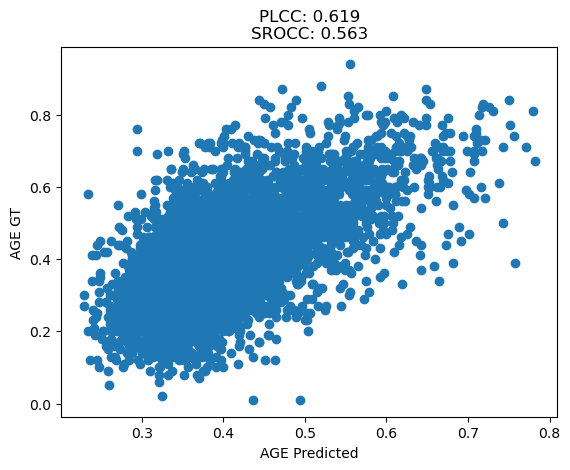

2, [67, 674] loss: 0.0779	PLCC: 0.651	SROCC: 0.610	lr: 0.000971
2, [134, 674] loss: 0.0784	PLCC: 0.628	SROCC: 0.581	lr: 0.000965
2, [201, 674] loss: 0.0778	PLCC: 0.654	SROCC: 0.614	lr: 0.000959
2, [268, 674] loss: 0.0771	PLCC: 0.639	SROCC: 0.599	lr: 0.000953
2, [335, 674] loss: 0.0761	PLCC: 0.658	SROCC: 0.607	lr: 0.000946
2, [402, 674] loss: 0.0755	PLCC: 0.657	SROCC: 0.614	lr: 0.000939
2, [469, 674] loss: 0.0735	PLCC: 0.658	SROCC: 0.604	lr: 0.000931
2, [536, 674] loss: 0.0776	PLCC: 0.630	SROCC: 0.581	lr: 0.000923
2, [603, 674] loss: 0.0758	PLCC: 0.650	SROCC: 0.596	lr: 0.000915
2, [670, 674] loss: 0.0761	PLCC: 0.646	SROCC: 0.613	lr: 0.000906
Validation loss: 0.073869	PLCC: 0.654	SROCC: 0.609


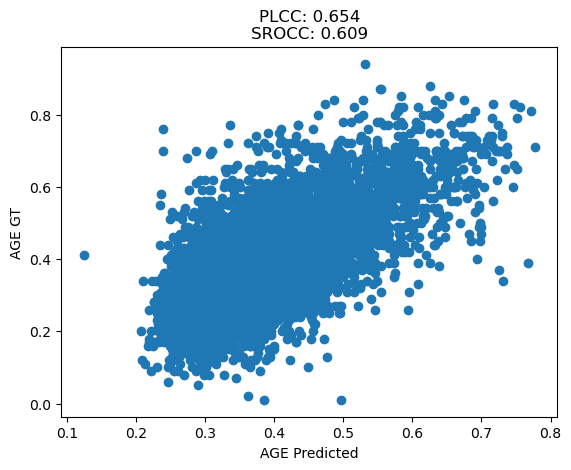

3, [67, 674] loss: 0.0703	PLCC: 0.708	SROCC: 0.661	lr: 0.000896
3, [134, 674] loss: 0.0698	PLCC: 0.694	SROCC: 0.664	lr: 0.000887
3, [201, 674] loss: 0.0722	PLCC: 0.679	SROCC: 0.633	lr: 0.000876
3, [268, 674] loss: 0.0708	PLCC: 0.713	SROCC: 0.658	lr: 0.000866
3, [335, 674] loss: 0.0728	PLCC: 0.683	SROCC: 0.640	lr: 0.000855
3, [402, 674] loss: 0.0724	PLCC: 0.688	SROCC: 0.632	lr: 0.000844
3, [469, 674] loss: 0.0723	PLCC: 0.693	SROCC: 0.651	lr: 0.000833
3, [536, 674] loss: 0.0717	PLCC: 0.694	SROCC: 0.656	lr: 0.000821
3, [603, 674] loss: 0.0705	PLCC: 0.717	SROCC: 0.677	lr: 0.000809
3, [670, 674] loss: 0.0735	PLCC: 0.681	SROCC: 0.648	lr: 0.000797
Validation loss: 0.072104	PLCC: 0.671	SROCC: 0.621


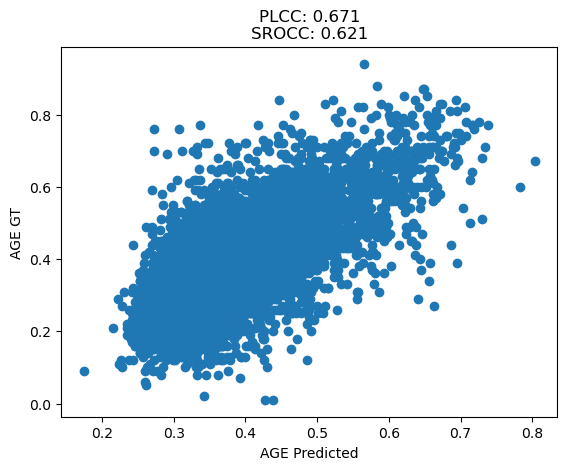

4, [67, 674] loss: 0.0676	PLCC: 0.744	SROCC: 0.698	lr: 0.000783
4, [134, 674] loss: 0.0679	PLCC: 0.731	SROCC: 0.691	lr: 0.000770
4, [201, 674] loss: 0.0654	PLCC: 0.763	SROCC: 0.716	lr: 0.000757
4, [268, 674] loss: 0.0671	PLCC: 0.736	SROCC: 0.697	lr: 0.000744
4, [335, 674] loss: 0.0681	PLCC: 0.718	SROCC: 0.708	lr: 0.000730
4, [402, 674] loss: 0.0670	PLCC: 0.732	SROCC: 0.699	lr: 0.000716
4, [469, 674] loss: 0.0654	PLCC: 0.738	SROCC: 0.703	lr: 0.000702
4, [536, 674] loss: 0.0680	PLCC: 0.723	SROCC: 0.684	lr: 0.000688
4, [603, 674] loss: 0.0666	PLCC: 0.738	SROCC: 0.699	lr: 0.000673
4, [670, 674] loss: 0.0664	PLCC: 0.734	SROCC: 0.687	lr: 0.000659
Validation loss: 0.071571	PLCC: 0.675	SROCC: 0.632


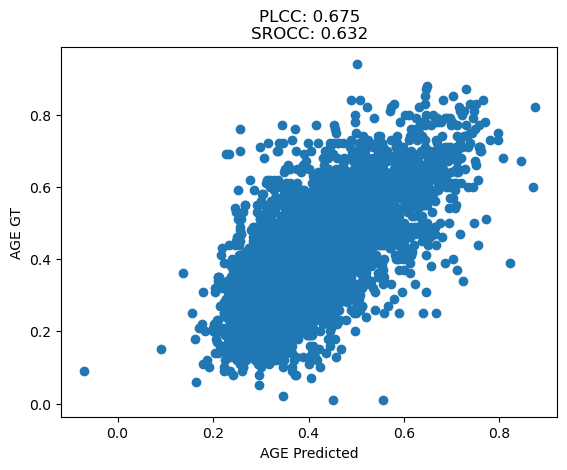

5, [67, 674] loss: 0.0612	PLCC: 0.774	SROCC: 0.746	lr: 0.000643
5, [134, 674] loss: 0.0607	PLCC: 0.777	SROCC: 0.754	lr: 0.000628
5, [201, 674] loss: 0.0603	PLCC: 0.778	SROCC: 0.756	lr: 0.000613
5, [268, 674] loss: 0.0625	PLCC: 0.761	SROCC: 0.724	lr: 0.000598
5, [335, 674] loss: 0.0600	PLCC: 0.772	SROCC: 0.751	lr: 0.000583
5, [402, 674] loss: 0.0625	PLCC: 0.784	SROCC: 0.745	lr: 0.000568
5, [469, 674] loss: 0.0604	PLCC: 0.785	SROCC: 0.752	lr: 0.000552
5, [536, 674] loss: 0.0619	PLCC: 0.775	SROCC: 0.746	lr: 0.000537
5, [603, 674] loss: 0.0611	PLCC: 0.778	SROCC: 0.750	lr: 0.000521
5, [670, 674] loss: 0.0618	PLCC: 0.755	SROCC: 0.742	lr: 0.000506
Validation loss: 0.071550	PLCC: 0.679	SROCC: 0.639


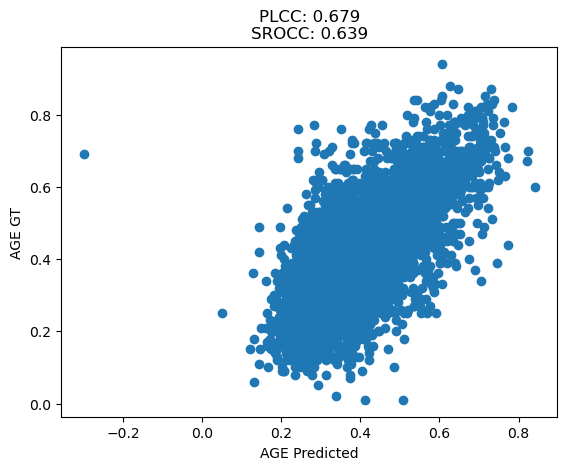

6, [67, 674] loss: 0.0561	PLCC: 0.807	SROCC: 0.795	lr: 0.000490
6, [134, 674] loss: 0.0567	PLCC: 0.807	SROCC: 0.798	lr: 0.000474
6, [201, 674] loss: 0.0571	PLCC: 0.793	SROCC: 0.775	lr: 0.000459


KeyboardInterrupt: 

In [59]:
# Training loop
for epoch in range(epochs):  # Loop over the dataset for multiple epochs
    running_loss = []  # List to store training loss for each batch
    gt_labels = []  # List to store ground truth labels (predicted age)
    pr_labels = []  # List to store predicted labels (model output)

    net.train()  # Set the model to training mode (enables dropout and other training-specific behaviors)

    for i, data in enumerate(trainloader):
        # Get inputs and labels from the data loader
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.cpu().numpy())   # Append ground truth

        inputs = inputs.to(device)  # Move data to the appropriate device (CPU or GPU)
        labels = labels.to(device)  # Move labels to the appropriate device

        # Zero the parameter gradients before each backward pass
        optimizer.zero_grad()

        # Forward pass, calculate loss
        outputs = net(inputs)  # Get model predictions

        loss = criterion(outputs.squeeze(), labels)  # Calculate L1 loss between predictions and true labels
        pr_labels.append(outputs.squeeze().detach().cpu())  # Store predictions (detach to avoid gradients)

        # Backward pass and parameter update
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights based on gradients
        scheduler.step()  # Update learning rate according to the scheduler

        # Print statistics (every 10% of the training data)
        running_loss.append(loss.item())
        if (i + 1) % (len(trainloader) // 10) == 0:  # Every 10% of the epoch
            gt_labels = np.stack(list(itertools.chain.from_iterable(gt_labels))).squeeze()  # Combine ground truth labels
            pr_labels = np.stack(list(itertools.chain.from_iterable(pr_labels))).squeeze()  # Combine predictions

            # Calculate and print performance metrics (PLCC, SROCC, learning rate)
            s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
            p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
            print('%d, [%d, %d] loss: %.4f\tPLCC: %.3f\tSROCC: %.3f\tlr: %.6f' %
                  (epoch + 1, i + 1, len(trainloader), np.mean(running_loss), p, s, optimizer.param_groups[-1]['lr']))

            # Clear lists for next iteration within the epoch
            gt_labels = []
            pr_labels = []
            running_loss = []

    # Validation loop (after each training epoch)
    running_loss = []  # List to store validation loss for each batch
    gt_labels = []  # List to store ground truth labels (predicted age)
    pr_labels = []  # List to store predicted labels (model output)

    net.eval()  # Set the model to evaluation mode (deactivates dropout and other training behaviors)

    for i, data in enumerate(valloader):
        # Get inputs and labels from the data loader
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.item())  # Append ground truth as single values

        inputs = inputs.to(device)  # Move data to the appropriate device
        labels = labels.to(device)  # Move labels to the appropriate device

        # Forward pass with gradient suppression
        with torch.no_grad():
            outputs = net(inputs)  # Get model predictions without calculating gradients

        pr_labels.append(outputs.squeeze().item())  # Append predictions as single values
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Calculate L1 loss
        running_loss.append(loss.item())

    # Calculate and print validation performance metrics
    gt_labels = np.stack(gt_labels)  # Combine ground truth labels
    pr_labels = np.stack(pr_labels)  # Combine predictions
    s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
    p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
    print('Validation loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

    # Visualization (optional)
    plt.scatter(pr_labels, gt_labels)
    plt.xlabel("AGE Predicted")
    plt.ylabel("AGE GT")
    plt.title("PLCC: %.3f\nSROCC: %.3f" % (p, s))
    plt.show()

    # Save the model (optional)
    torch.save(net.state_dict(), f"net_last_e{epoch}.pth")  # Save model state after each epoch

print('Finished Training')